In [45]:
import numpy as np
import time
from pathlib import Path
from typing import Tuple, List, Dict
import torch
import matplotlib.pyplot as plt

In [ ]:
class CarSimulation:
    def __init__(self, model_path: str, target_laps: int = 2):
        self.model, self.ckpt = self._load_model(model_path)
        self._init_parameters()
        
        self.state = {
            'fsm_state': DRIFT,
            'laps': 0,
            'prev_yaw': 0.0,
            'angle_accum': 0.0,
            't0': 0,
            'log': []
        }
        
        self.target_laps = target_laps
        self.dt = 0.1  # step in sec
        
    def _load_model(self, pt_path: str) -> Tuple[DynNet, dict]:
        """load model from checkpoint file."""
        ckpt = torch.load(pt_path, map_location="cpu", weights_only=False)
        hidden = ckpt["net"]["net.0.weight"].shape[0]
        model = DynNet(hidden_dim=hidden)
        model.load_state_dict(ckpt["net"])
        model.eval()
        return model, ckpt
    
    def _init_parameters(self):
        """initialize all control parameters from checkpoint."""
        self.MU_S,  self.SIG_S  = self._ckpt_val("mu_s", "mu_X"), self._ckpt_val("sig_s", "sig_X")
        self.MU_A,  self.SIG_A  = self._ckpt_val("mu_a", "mu_Y"), self._ckpt_val("sig_a", "sig_Y")
        self.MU_SN, self.SIG_SN = self._ckpt_val("mu_sn", "mu_Y"), self._ckpt_val("sig_sn", "sig_Y")
        self.MU_A = self.MU_A[:2]
        self.SIG_A = self.SIG_A[:2]
    
    def _ckpt_val(self, prefer_a: str, prefer_b: str):
        """get value from checkpoint by preferred keys."""
        if prefer_a in self.ckpt:
            return self.ckpt[prefer_a]
        if prefer_b in self.ckpt:
            return self.ckpt[prefer_b]
        raise KeyError(f"{prefer_a}/{prefer_b} not found in checkpoint")
    
    def _norm(self, x: np.ndarray, mu: np.ndarray, sig: np.ndarray) -> np.ndarray:
        return (x - mu) / sig
    
    def _denorm(self, x: torch.Tensor, mu: np.ndarray, sig: np.ndarray) -> torch.Tensor:
        return x * torch.from_numpy(sig) + torch.from_numpy(mu)
    
    def mpc_control(self, state_now: np.ndarray) -> Tuple[int, int]:
        """calculate steering and gas commands using MPC."""
        with torch.no_grad():
            s0 = torch.tensor(self._norm(state_now, self.MU_S, self.SIG_S), dtype=torch.float32)
            s = self.model(s0)
            
            yaw, ay, beta, _ = map(float, self._denorm(s, self.MU_SN, self.SIG_SN))
            base_cost = yaw ** 2 + 0.5 * ay ** 2 + 0.2 * beta ** 2

            a_seq = torch.normal(0.0, SIGMA, size=(N_SAMPLES, HORIZON, 2))
            a_norm = (a_seq - torch.from_numpy(self.MU_A)) / torch.from_numpy(self.SIG_A)

            s_batch = s.repeat(N_SAMPLES, 1)
            costs = torch.full((N_SAMPLES,), base_cost)

            for t in range(1, HORIZON):
                inp = torch.cat([s_batch, a_norm[:, t, :]], dim=1)
                s_batch = self.model(inp)
                yaw, ay, beta, _ =  map(float, self._denorm(s, self.MU_SN, self.SIG_SN))
                costs += yaw ** 2 + 0.5 * ay ** 2 + 0.2 * beta ** 2

            best_idx = int(torch.argmin(costs))
            best_action = a_seq[best_idx, 0]

        steer_pwm = int(np.clip(best_action[0].item() * STEER_SP + STEER_C,
                                STEER_MIN, STEER_MAX))
        gas_pwm   = int(np.clip(best_action[1].item() * GAS_SP + GAS_C,
                                GAS_MIN, GAS_MAX))
        return steer_pwm, gas_pwm
    
    def update_state(self, yaw_rate: float, ay_world: float) -> Dict:
        """Update the car's state and return commands."""
        t = self.state['t0'] + int(self.dt * 1000) 
        
        yaw_integrated = self.state['prev_yaw'] + yaw_rate * self.dt
        self.state['angle_accum'] += yaw_rate * self.dt
        
        # check for completed lap
        if (self.state['prev_yaw'] < 0 <= yaw_integrated or 
            self.state['angle_accum'] >= 360.0):
            self.state['laps'] += 1
            self.state['angle_accum'] = self.state['angle_accum'] % 360.0
            print(f"Lap {self.state['laps']}")
        
        state_now = np.array([yaw_rate, ay_world, 0.0, 0.0, 0.0, 0.0])
        
        # FSM logic
        if self.state['fsm_state'] == DRIFT:
            if self.state['laps'] >= self.target_laps:
                self.state['fsm_state'] = RECOVERY
                print("→ RECOVERY")

            err = YAW_SP - yaw_rate
            steer_cmd = int(np.clip(STEER_C + PID_KP * err * STEER_SP,
                                    STEER_MIN, STEER_MAX))
            gas_cmd = GAS_DURING_DRIFT

        elif self.state['fsm_state'] == RECOVERY:
            steer_cmd, gas_cmd = self.mpc_control(state_now)
            if abs(yaw_rate) < 30 and abs(ay_world) < 1:
                self.state['fsm_state'] = IDLE
                print("→ IDLE")

        else:  # IDLE
            steer_cmd, gas_cmd = STEER_C, GAS_MIN
        
        log_entry = {
            'time': t,
            'steer': steer_cmd,
            'gas': gas_cmd,
            'yaw': yaw_integrated,
            'laps': self.state['laps'],
            'fsm_state': self.state['fsm_state']
        }
        self.state['log'].append(log_entry)
        
        self.state['prev_yaw'] = yaw_integrated
        self.state['t0'] = t
        
        return log_entry
    
    def run_simulation(self, duration: float, sensor_callback=None):
        """run simulation for specified duration."""
        start_time = time.time()
        iterations = int(duration / self.dt)
        
        for _ in range(iterations):
            if sensor_callback:
                yaw_rate, ay_world = sensor_callback()
            else:
                yaw_rate, ay_world = self._generate_sensor_data()
            
            self.update_state(yaw_rate, ay_world)
            
            # add delay to simulate real-time operation
            time.sleep(self.dt)
        
        print(f"Simulation completed. Ran for {duration:.1f} seconds.")
        return self.state['log']
    
    def _generate_sensor_data(self) -> Tuple[float, float]:
        """generate simulated sensor data."""
        if self.state['fsm_state'] == DRIFT:
            yaw_rate = YAW_SP + np.random.normal(0, 10)
            ay_world = 2.0 + np.random.normal(0, 0.3)
        elif self.state['fsm_state'] == RECOVERY:
            yaw_rate = 50 * (1 - self.state['laps']/self.target_laps) + np.random.normal(0, 5)
            ay_world = 1.0 + np.random.normal(0, 0.2)
        else:  # IDLE
            yaw_rate = np.random.normal(0, 1)
            ay_world = np.random.normal(0, 0.1)
        
        return yaw_rate, ay_world
    
    def save_log(self, filename: str):
        """save simulation log to csv."""
        import csv
        with open(filename, 'w', newline='') as csvfile:
            fieldnames = ['time', 'steer', 'gas', 'yaw', 'laps', 'fsm_state']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            
            writer.writeheader()
            for entry in self.state['log']:
                writer.writerow(entry)
        
        print(f"Log saved to {filename}")

In [26]:
DRIFT, RECOVERY, IDLE = range(3)
TARGET_LAPS = 2
YAW_SP = 280.0
PID_KP = 0.004
STEER_MIN, STEER_MAX = 1968, 4004
GAS_MIN, GAS_MAX = 1968, 4004
GAS_DURING_DRIFT = 4000
STEER_C = (STEER_MIN + STEER_MAX) / 2
STEER_SP = (STEER_MAX - STEER_MIN) / 2
GAS_C = (GAS_MIN + GAS_MAX) / 2
GAS_SP = (GAS_MAX - GAS_MIN) / 2
HORIZON, N_SAMPLES, SIGMA = 12, 150, 0.30


In [61]:
def plots(data):
    plt.figure(figsize=(5, 5))
    # trajectory Plot 
    ax1 = plt.subplot(2, 1, 1)
    theta_rad = np.deg2rad(data['yaw'])
    r = np.linspace(0, 1, len(theta_rad)) 

    # color by FSM state (0=DRIFT, 1=RECOVERY, 2=IDLE)
    state_colors = ['red', 'orange', 'green']
    for i in range(len(data)-1):
        x = r[i:i+2] * np.cos(theta_rad[i:i+2])
        y = r[i:i+2] * np.sin(theta_rad[i:i+2])
        ax1.plot(x, y, color=state_colors[data['fsm_state'][i]], alpha=0.8)

    # mark lap completions
    lap_indices = np.where(np.diff(data['laps']) > 0)[0]
    for idx in lap_indices:
        x = r[idx] * np.cos(theta_rad[idx])
        y = r[idx] * np.sin(theta_rad[idx])
        ax1.plot(x, y, 'bo', markersize=8)
        ax1.text(x, y, f' Lap {data["laps"][idx]+1}', va='bottom')

    ax1.set_title('Vehicle Trajectory (Yaw Angle)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.grid(True)
    ax1.axis('equal')

    # control inputs
    ax2 = plt.subplot(2, 1, 2)
    time_sec = data['time'] / 1000  # Convert ms to seconds

    ax2.plot(time_sec, data['steer'], 'b-', label='Steering')
    ax2.plot(time_sec, data['gas'], 'r-', label='Throttle')
    ax2.set_title('Control Inputs Over Time')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('PWM Value')
    ax2.grid(True)
    ax2.legend()

    # mark state transitions
    state_changes = np.where(np.diff(data['fsm_state']) != 0)[0]
    state_labels = ['DRIFT→RECOVERY', 'RECOVERY→IDLE']
    for i, idx in enumerate(state_changes):
        ax2.axvline(time_sec[idx], color='k', linestyle='--', alpha=0.5)
        # ax2.text(time_sec[idx], 3500, state_labels[i], rotation=90, va='top')

    plt.tight_layout()
    plt.show()

In [58]:
dtype = [
    ('time', 'f4'), 
    ('steer', 'f4'),
    ('gas', 'f4'),
    ('yaw', 'f4'),
    ('laps', 'i4'),
    ('fsm_state', 'i4')
]

Lap 1
→ RECOVERY
→ IDLE
Simulation completed. Ran for 7.0 seconds.


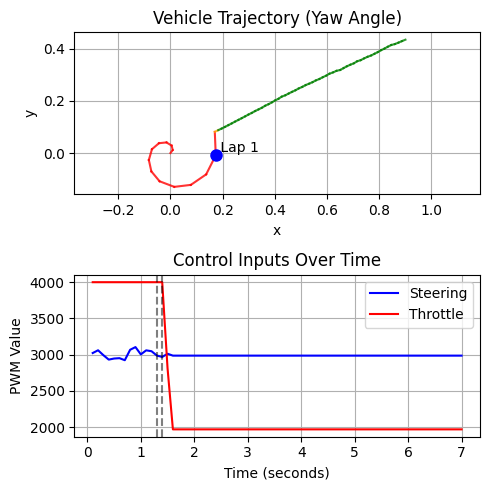

In [65]:
sim = CarSimulation("dyn_v3.pt", target_laps=1)
log = sim.run_simulation(duration=7.0)

data = np.array(
    [(d['time'], d['steer'], d['gas'], d['yaw'], d['laps'], d['fsm_state']) 
     for d in log],
    dtype=dtype
)
plots(data)

Lap 1
Lap 2
→ RECOVERY
→ IDLE
Simulation completed. Ran for 7.0 seconds.


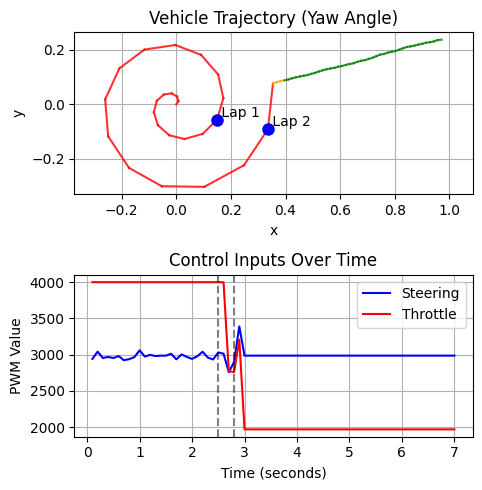

In [66]:
sim = CarSimulation("dyn_v3.pt", target_laps=2)
log = sim.run_simulation(duration=7.0)

data = np.array(
    [(d['time'], d['steer'], d['gas'], d['yaw'], d['laps'], d['fsm_state']) 
     for d in log],
    dtype=dtype
)
plots(data)

Lap 1
Lap 2
Lap 3
→ RECOVERY
→ IDLE
Simulation completed. Ran for 7.0 seconds.


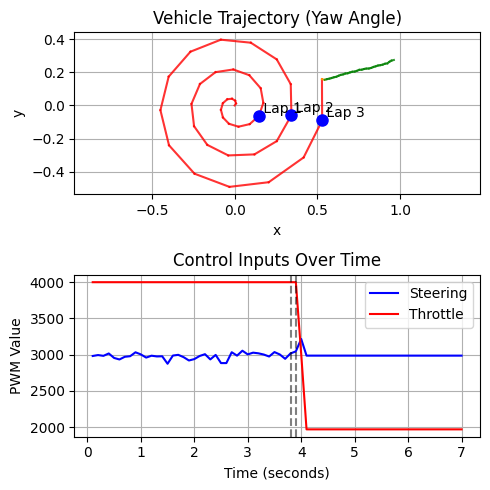

In [67]:
sim = CarSimulation("dyn_v3.pt", target_laps=3)
log = sim.run_simulation(duration=7.0)

data = np.array(
    [(d['time'], d['steer'], d['gas'], d['yaw'], d['laps'], d['fsm_state']) 
     for d in log],
    dtype=dtype
)
plots(data)

Lap 1
Lap 2
Lap 3
Lap 4
→ RECOVERY
→ IDLE
Simulation completed. Ran for 7.0 seconds.


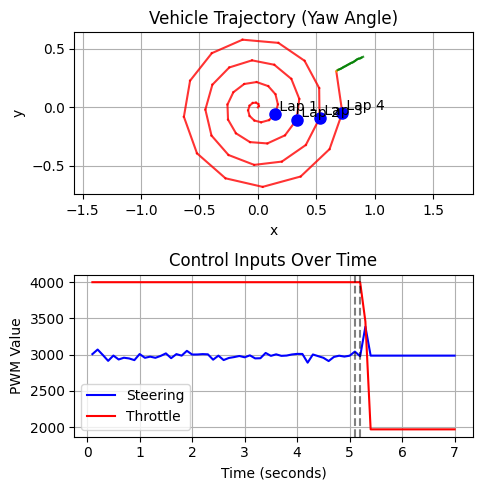

In [68]:
sim = CarSimulation("dyn_v3.pt", target_laps=4)
log = sim.run_simulation(duration=7.0)

data = np.array(
    [(d['time'], d['steer'], d['gas'], d['yaw'], d['laps'], d['fsm_state']) 
     for d in log],
    dtype=dtype
)
plots(data)